
# 🧪 Bayesian modelling of enzyme kinetics - Introduction

In this notebook, you will get hands-on experience with Bayesian modeling for enzyme kinetics.  
We will use synthetic data from a simple irreversible first-order reaction:

$P(t) = S_0 \cdot (1-e^{-k t})$

You will learn:
- how to set up this model in PyMC,
- how to use prior knowledge about reaction rate constants,
- how to evaluate and visualise posteriors.


In [1]:
# Install PyMC if not already installed
!pip install pymc --quiet

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

rng = np.random.default_rng(42)

/opt/homebrew/Caskroom/miniforge/base/envs/aims-teaching311/lib/python3.11/site-packages/arviz/__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


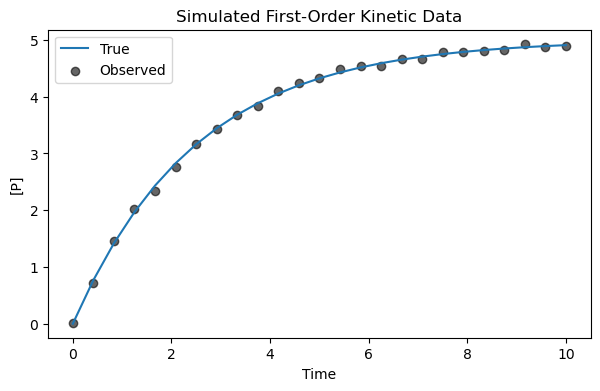

In [3]:
# True parameters
S0_true = 5.0  # initial concentration
k_true = 0.4   # rate constant

# Generate time points and data
time = np.linspace(0, 10, 25)
P_obs = S0_true * (1- np.exp(-k_true * time))

# Add Gaussian noise
sigma = 0.05
P_noisy = P_obs + rng.normal(0, sigma, size=P_obs.shape)

plt.figure(figsize=(7, 4))
plt.plot(time, P_obs, label="True")
plt.scatter(time, P_noisy, color="black", label="Observed", alpha=0.6)
plt.xlabel("Time")
plt.ylabel("[P]")
plt.legend()
plt.title("Simulated First-Order Kinetic Data")
plt.show()


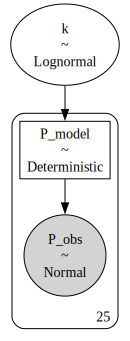

In [4]:
with pm.Model() as model:
    # Priors
    k = pm.LogNormal("k", mu=np.log(0.5), sigma=0.5)

    # Deterministic equation for kinetics
    P_model = pm.Deterministic("P_model", S0_true * (1 - pm.math.exp(-k * time)))

    # Likelihood
    P_obs_data = pm.Normal("P_obs", mu=P_model, observed=P_noisy)

# Visualise the computatin graph of your model
model.to_graphviz()


In [5]:
with model:
    # Inference
    trace = pm.sample(1000, chains=4, tune=1000, target_accept=0.9, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


/opt/homebrew/Caskroom/miniforge/base/envs/aims-teaching311/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


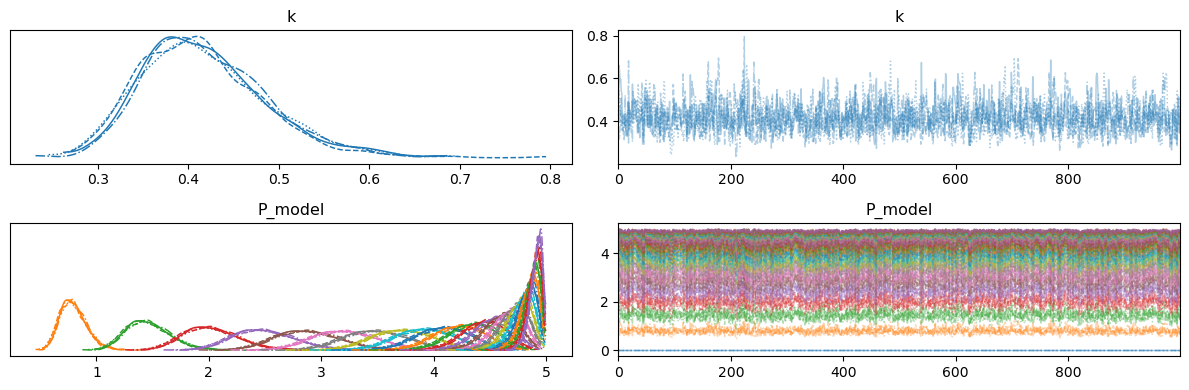

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,0.417,0.068,0.293,0.539,0.002,0.001,1383.0,1704.0,1.0


In [6]:
az.plot_trace(trace, var_names=["k", "P_model"])
plt.tight_layout()
plt.show()

az.summary(trace, var_names=["k"]) #["k", "P_model"]

Sampling: []


Output()

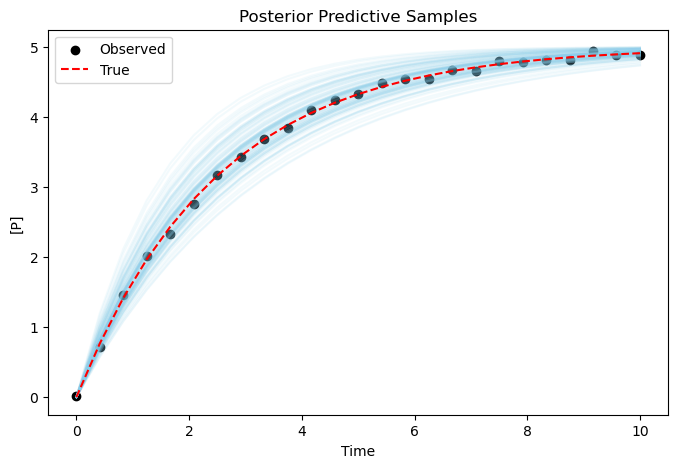

In [7]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["P_model"])

plt.figure(figsize=(8, 5))
for i in range(100):
    plt.plot(time, ppc.posterior_predictive["P_model"].stack(sample=("chain", "draw"))[:, i], color="skyblue", alpha=0.1)
plt.scatter(time, P_noisy, color="black", label="Observed")
plt.plot(time, P_obs, color="red", label="True", linestyle="--")
plt.xlabel("Time")
plt.ylabel("[P]")
plt.legend()
plt.title("Posterior Predictive Samples")
plt.show()


### ✍️ Exercise:

Try changing the prior for `k` to something less informative, e.g.:

```python
k = pm.Uniform("k", lower=0.01, upper=1.0)
```

How does that affect the posterior?

Bonus:
- Can you also model `S0` as unknown instead of fixed to the true value?
- Can you visualise the posterior instead of the posterior predictive for the given example? Why are the two different? (Hint: you have to use `trace.posterior`.)



Next, we’ll explore how to let unknown *process conditions* (like pH and temperature) influence reaction rates via latent functions — using **Gaussian processes**.
